# Thompson sampling a 1-dimensional problem with `sklearn` and `pyrff`
This example shows how to do Bayesian optimization with by Thompson sampling with Gaussian processes on a 1-dimensional synthetic problem.

It uses the [`GaussianProcessRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html) from scikit-learn to fit the Gaussian process and `pyrff` to sample continuous functions from it, via the Random Fourier Feature approximation method  [[1]](https://arxiv.org/abs/1511.05467).

The continuous functions are optimized by multi-start local optimization to obtain approximate samples from the distribution over the GPs global maximum. In line with the Thompson sampling algorithm, they are used as the design points for new batches of experiments.

<div style="text-align: right"> by <a href="https://github.com/michaelosthege">Michael Osthege</a></div>

In [1]:
import fastprogress
import numpy
import pandas
from matplotlib import pyplot, cm
import sklearn.gaussian_process as skgp
import pathlib
import pymc3
import IPython.display
import imageio

import pyrff

# Set up a synthetic groundtruth
A truth function is created as the overlay of two sine and an exponential function. It is observed with normally distributed observation error $\sigma_{true}$.

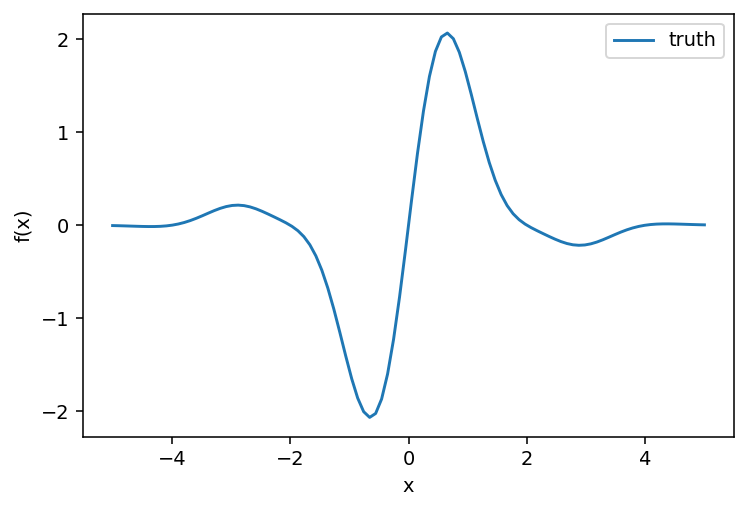

In [2]:
σ_true = 0.1
D = 1
dnames = [f'D{d}' for d in range(D)]
BOUNDS = (-5, 5)

def truth(x):
    y = (3 * numpy.sin((0.5*numpy.pi)*x) + numpy.sin((1*numpy.pi)*x)) / 1.5
    return y * numpy.exp(-(x/2)**2)

def observe(x, sigma=σ_true):
    y = truth(x)
    return numpy.random.normal(y[:,0], sigma, size=(len(x),))

# create coordinates for plotting
x_dense = numpy.linspace(*BOUNDS, num=100)[:,None]

# visualize
if D == 1:
    fig, ax = pyplot.subplots(dpi=140)
    ax.plot(x_dense, truth(x_dense), label='truth')
    ax.set_ylabel('f(x)')
    ax.set_xlabel('x')
    ax.legend()
    pyplot.show()

The following helper functions are used in every iteration of the Bayesian optimization. With `fit_gp`, a scikit-learn Gaussian process model is fitted to the available data. For the RFF method it's important to keep in mind, that the Gaussian process must be built with a constant 0-mean, a Matern or RBF kernel and a normally distributed likelihood.

In [3]:
def fit_gp(X, Y) -> skgp.GaussianProcessRegressor:
    k_cov = skgp.kernels.RBF(1, (0.5, 2))
    k_scaling = skgp.kernels.ConstantKernel(1, (0.1, 5))
    k_noise = skgp.kernels.WhiteKernel(noise_level=numpy.ptp(Y) / 10)
    gpr = skgp.GaussianProcessRegressor(
        kernel=k_scaling * k_cov + k_noise,
        random_state=0
    ).fit(X, Y)
    return gpr

def plot_comparison(X, Y, gpr, rffs):
    fig, (left, right) = pyplot.subplots(ncols=2, dpi=140, figsize=(10,5), sharey='row')

    y_pred, sigma = gpr.predict(x_dense, return_std=True)
    left.plot(x_dense, y_pred, 'b-', label='Prediction')
    left.fill(
        numpy.concatenate([x_dense, x_dense[::-1]]),
        numpy.concatenate([
            y_pred - 1.9600 * sigma,
            (y_pred + 1.9600 * sigma)[::-1]]
        ),
        alpha=.5, fc='b', ec='None', label='95% confidence interval'
    )
    left.plot(x_dense, truth(x_dense))
    left.scatter(X[:,0], Y)

    pymc3.gp.util.plot_gp_dist(
        right,
        x=x_dense,
        samples=numpy.array([rff(x_dense) for rff in rffs])
    )
    right.plot(x_dense, truth(x_dense))
    right.scatter(X[:,0], Y)
    left.set_ylim(-5, 5)
    return fig, (left, right)

# Iterative Bayesian optimization with Thompson sampling
The next cell runs a fixed number of optimization rounds with a given batch size. The `x` coordinates for the first round are uniformly sampled in the `BOUNDS` defined earlier. In every iteration, the following steps are performed:
1. make observations at the `x` coordinates
2. fit a GP to all data so far
3. sample RFF approximations with `pyrff`
4. run optimization to find the x-coordinate of their maximum
5. set the `x` coordinates to the maximum of the sampled functions

You can play with the random seed to get a feeling for the overall performance.

In [4]:
numpy.random.seed(2021)

BATCH_SIZE = 3
N_rffs = 50
N_rounds = 30
M = 100
dp_results = pathlib.Path('TS_1D')
dp_results.mkdir(exist_ok=True)

df_observations = pandas.DataFrame(columns=['round', *dnames, 'y']).set_index(['round', *dnames])
x = numpy.random.uniform(*BOUNDS, size=(BATCH_SIZE, 1))
for r in fastprogress.progress_bar(range(N_rounds)):
    # begin by making observations
    y = observe(x)
    for x_, y_ in zip(x, y):
        df_observations.loc[(0, *x_), 'y'] = y_
    
    # slice current data to array
    df = df_observations.reset_index()
    X = df[dnames].values.astype(float)
    Y = df.y.values.astype(float)
    # fit model
    gpr = fit_gp(X, Y)
    # sample rffs
    rffs = [
        pyrff.sample_rff(
            lengthscales=gpr.kernel_.k1.k2.length_scale,
            scaling=gpr.kernel_.k1.k1.constant_value,
            noise=gpr.kernel_.k2.noise_level,
            kernel_nu=numpy.inf,
            X=X, Y=Y,
            M=M
        )
        for n in range(N_rffs)
    ]
    pyrff.save_rffs(rffs, pathlib.Path(dp_results, f'rffs_round_{r:02d}.h5'))
    fig, axs = plot_comparison(X, Y, gpr, rffs)
    fig.suptitle(f'Round {r}')
    fig.savefig(pathlib.Path(dp_results, f'comparison_round_{r:02d}.png'))
    pyplot.close()
    # run optimization on posterior samples
    x_star_x = []
    for irff in numpy.random.permutation(N_rffs)[:BATCH_SIZE]:
        rff = rffs[irff]
        x_best, y_best = pyrff.multi_start_fmin(
            fun=rff,
            x0s=numpy.random.uniform(*BOUNDS, size=(50, D)),
        )
        x_star_x.append(x_best)
    # set x for the next round to the argmax results:
    x = numpy.array(x_star_x)

# Visualize results
The next cell reads the plots written by the function above and combines them into a GIF.

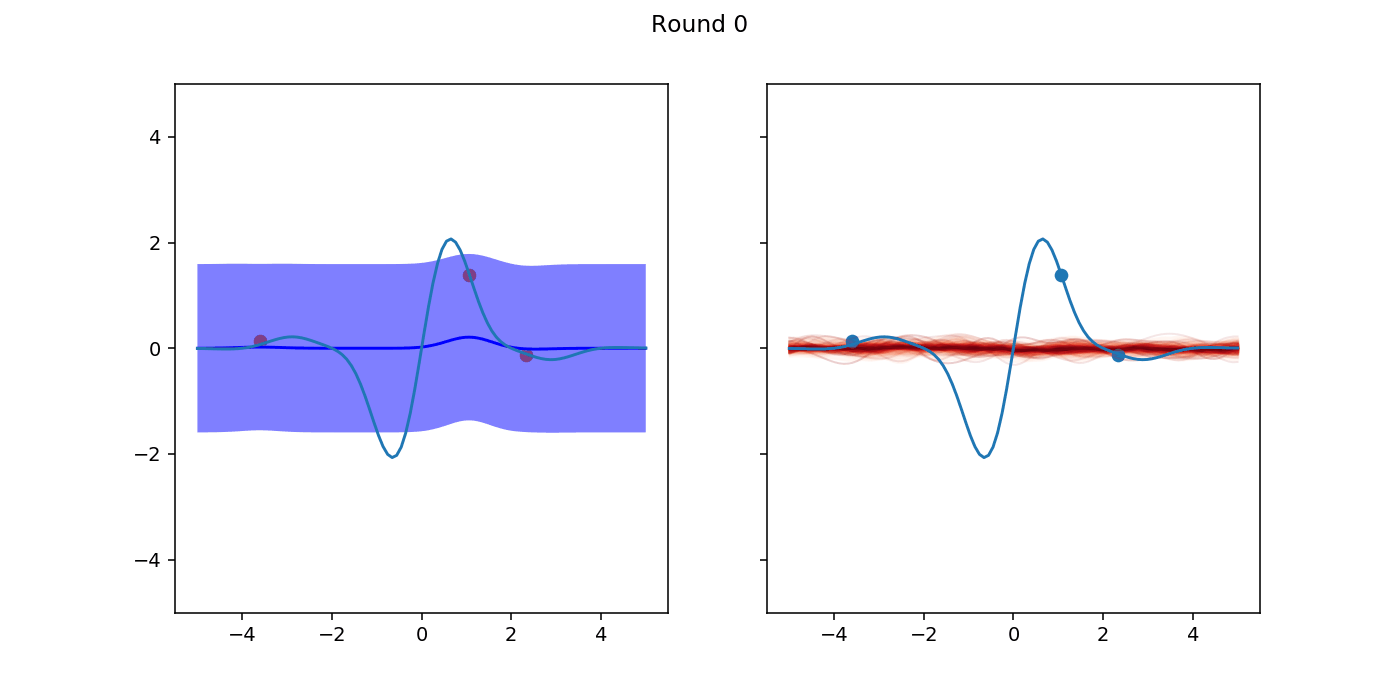

In [5]:
fp_gif = pathlib.Path(dp_results, 'result.gif')
writer = imageio.get_writer(fp_gif, fps=2)
for r in range(N_rounds):
    img = imageio.imread(pathlib.Path(dp_results, f'comparison_round_{r:02d}.png'))
    writer.append_data(img)
writer.close()
IPython.display.Image(data=open(fp_gif, 'rb').read(), embed=True)